# 🎯 LangGraph UQLM Demo

<div style="background-color: rgba(200, 200, 200, 0.1); padding: 20px; border-radius: 8px; margin-bottom: 20px; border: 1px solid rgba(127, 127, 127, 0.2); max-width: 97.5%; overflow-wrap: break-word;">
  <p style="font-size: 16px; line-height: 1.6">
    This demo provides an illustration 
    of how to use LangGraph with <code>uqlm</code>. Please note in that installation of LangGraph is required before running this tutorial.
  </p>
</div>

## 📊 What You'll Do in This Demo

<div style="display: flex; margin-bottom: 15px; align-items: center">
  <div style="background-color: #34a853; color: white; border-radius: 50%; width: 30px; height: 30px; display: flex; justify-content: center; align-items: center; margin-right: 15px; flex-shrink: 0"><strong>1</strong></div>
  <div>
    <p style="margin: 0; font-weight: bold"><a href=#section1>Set up LLM and prompts.</a></p>
    <p style="margin: 0; color: rgba(95, 99, 104, 0.8)">Set up LLM instance and load example data prompts.</p>
  </div>
</div>

<div style="display: flex; margin-bottom: 15px; align-items: center">
  <div style="background-color: #34a853; color: white; border-radius: 50%; width: 30px; height: 30px; display: flex; justify-content: center; align-items: center; margin-right: 15px; flex-shrink: 0"><strong>2</strong></div>
  <div>
    <p style="margin: 0; font-weight: bold"><a href=#section2>Create a simple LangGraph agent.</a></p>
    <p style="margin: 0; color: rgba(95, 99, 104, 0.8)">Create a simple LangGraph agent workflow.</p>
  </div>
</div>

<div style="display: flex; margin-bottom: 25px; align-items: center">
  <div style="background-color: #34a853; color: white; border-radius: 50%; width: 30px; height: 30px; display: flex; justify-content: center; align-items: center; margin-right: 15px; flex-shrink: 0"><strong>3</strong></div>
  <div>
    <p style="margin: 0; font-weight: bold"><a href=#section3>Evaluate Hallucination Detection Performance</a></p>
    <p style="margin: 0; color: rgba(95, 99, 104, 0.8)">Visualize model accuracy at different thresholds of the various white-box UQ confidence scores. Compute precision, recall, and F1-score of hallucination detection.</p>
  </div>
</div>

## ⚖️ Advantages & Limitations

<div style="display: flex; gap: 20px">
  <div style="flex: 1; background-color: rgba(0, 200, 0, 0.1); padding: 15px; border-radius: 8px; border: 1px solid rgba(0, 200, 0, 0.2)">
    <h3 style="color: #2e8b57; margin-top: 0">Pros</h3>
    <ul style="margin-bottom: 0">
      <li><strong>Universal Compatibility:</strong> Works with any LLM</li>
      <li><strong>Intuitive:</strong> Easy to understand and implement</li>
    </ul>
  </div>
  
  <div style="flex: 1; background-color: rgba(200, 0, 0, 0.1); padding: 15px; border-radius: 8px; border: 1px solid rgba(200, 0, 0, 0.2)">
    <h3 style="color: #b22222; margin-top: 0">Cons</h3>
    <ul style="margin-bottom: 0">
      <li><strong>Higher Cost & Latency:</strong> Multiple generations and multi-node workflows may add overhead cost and latency</li>
    </ul>
  </div>
</div>

In [1]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

from uqlm import WhiteBoxUQ
from uqlm.utils import load_example_dataset, plot_model_accuracies, Tuner, LLMGrader

<a id='section1'></a>
## 1. Set up LLM and Prompts

In this demo, we will illustrate this approach using a set of short answer questions from the [PopQA benchmark](https://arxiv.org/abs/2212.10511). To implement with your use case, simply **replace the example prompts with your data**.  

In [2]:
# Load example dataset (popqa)
popqa = load_example_dataset("popqa", n=100)
popqa.head()

Loading dataset - popqa...


Repo card metadata block was not found. Setting CardData to empty.


Processing dataset...
Dataset ready!


,question,answer
0,What is George Rankin's occupation?,"[politician, political leader, political figur..."
1,What is John Mayne's occupation?,"[journalist, journo, journalists]"
2,What is Henry Feilden's occupation?,"[politician, political leader, political figur..."
3,What is Kathy Saltzman's occupation?,"[politician, political leader, political figur..."
4,What is Eleanor Davis's occupation?,"[cartoonist, graphic artist, animator, illustr..."


In [3]:
# Define prompts
INSTRUCTION = "You will be given a question. Return only the answer as concisely as possible without providing an explanation.\n"
prompts = [INSTRUCTION + prompt for prompt in popqa.question]

In this example, we use `ChatVertexAI` to instantiate our LLM, but any [LangChain Chat Model](https://js.langchain.com/docs/integrations/chat/) may be used. Be sure to **replace with your LLM of choice.**

In [4]:
# import sys
# !{sys.executable} -m pip install langchain-openai

## User to populate .env file with API credentials
from dotenv import load_dotenv, find_dotenv
from langchain_google_vertexai import ChatVertexAI

load_dotenv(find_dotenv())

# Initialize the model
llm = ChatVertexAI(
    model_name="gemini-2.5-flash",
    temperature=0.7
 )

<a id='section2'></a>
## 2. Generate LLM Responses and Confidence Scores within LangGraph Workflow

Here, we build a sample LangGraph agent that utilizes a <code>WhiteBoxUQ()</code> scorer, flags low confidence generations based on a fixed threshold, and interprets the sampled responses generated. For more info on <code>WhiteBoxUQ()</code> class, refer to the [WhiteBoxUQ tutorial notebook](https://github.com/cvs-health/uqlm/blob/main/examples/white_box_multi_generation_demo.ipynb). If your LLM does not support token probability access, you can utilize the <code>BlackBoxUQ()</code> class. Please refer to the [BlackBoxUQ tutorial notebook](https://github.com/cvs-health/uqlm/blob/main/examples/black_box_demo.ipynb) for more information.

In [5]:
wbuq = WhiteBoxUQ(
    llm=llm,
    scorers=[
        "consistency_and_confidence"  # requires multiple sampled responses per prompt
    ],
    max_calls_per_min=125,
)

In [6]:
from typing import Any, Dict, TypedDict, List
from langgraph.graph import END, StateGraph

# set up the LLM grader
grader = LLMGrader(llm=llm)

LOW_SCORE_THRESHOLD = 0.75

class QAState(TypedDict, total=False):
    prompts: List[str]
    uq: WhiteBoxUQ
    result_df: Any
    low_confidence_flags: List[bool]
    flagged_scores: List[Dict[str, float]]
    accuracy: float

async def run_whitebox(state: QAState) -> QAState:
    results = await state['uq'].generate_and_score(prompts=state['prompts'], 
                            num_responses=3)
    return {"result_df": results.to_df()}

def flag_low_confidence(state: QAState) -> QAState:
    result_df = state.get("result_df")
    updated_df = result_df.copy()
    
    # Check if any of the specified columns have values below the threshold
    score_columns = ["consistency_and_confidence"]
    updated_df["low_confidence_flag"] = updated_df[score_columns].min(axis=1) < LOW_SCORE_THRESHOLD
    
    # Add a high-risk flag for rows with low confidence
    updated_df["risk_level"] = updated_df["low_confidence_flag"].apply(lambda x: "High" if x else "Low")
    
    print(f"Flagged {updated_df['low_confidence_flag'].sum()} rows as low confidence.")
    return {"result_df": updated_df}

async def interpret_sampled_responses(state: QAState) -> QAState:
    result_df = state.get("result_df")
    eval_llm = ChatVertexAI(
        model_name="gemini-2.0-flash-lite-001",
        temperature=0.7)
    interpretations = []
    
    for index, row in result_df.iterrows():
        sampled_responses = row['sampled_responses']
        prompt = row['prompt']
        interp_prompt_template = """You will be given a question, an answer generated by an LLM, and sampled responses from the LLM. 
        Provide a 1-3 sentence interpretation of the sampled responses in regards to whether they are consistent or different and misconceptions the LLM may have.
        Return only the interpretation without any additional explanation. 
        Here is the prompt: {prompt}
        Here are the sampled responses: {sampled_responses}"""
        interp_prompt = interp_prompt_template.format(
            prompt=prompt,
            sampled_responses=sampled_responses
        )
        interpretation = eval_llm.invoke(interp_prompt).content
        interpretations.append(interpretation)
    result_df['interpretation'] = interpretations
    return {"result_df": result_df}

# Define nodes
agent_builder = StateGraph(QAState)
agent_builder.add_node("whitebox_uq", run_whitebox)
agent_builder.add_node("flag_low_confidence", flag_low_confidence)
agent_builder.add_node("interpret_sampled_responses", interpret_sampled_responses)

# Define edges
agent_builder.set_entry_point("whitebox_uq")
agent_builder.add_edge("whitebox_uq", "flag_low_confidence")
agent_builder.add_edge("flag_low_confidence", "interpret_sampled_responses")
agent_builder.add_edge("interpret_sampled_responses", END)

# Compile the agent
whitebox_agent = agent_builder.compile()

Visualizing the created LangGraph workflow

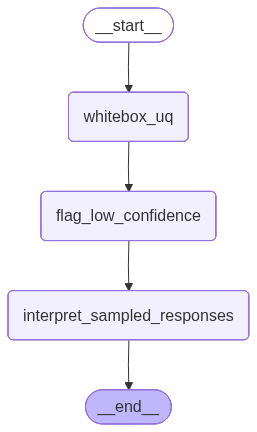

In [7]:
from IPython.display import Image, display

display(Image(whitebox_agent.get_graph().draw_mermaid_png()))

In [8]:
result_state = await whitebox_agent.ainvoke({"prompts": prompts, "uq": wbuq})

Output()

I0000 00:00:1768490823.657770   25541 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1768490823.708521   25541 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1768490823.759373   25541 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1768490823.811028   25541 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1768490823.860616   25541 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1768490823.912375   25541 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers


Flagged 38 rows as low confidence.


In [9]:
result_state['result_df']

,prompt,response,logprob,sampled_responses,sampled_logprob,consistency_and_confidence,low_confidence_flag,risk_level,interpretation
0,You will be given a question. Return only the ...,Footballer,"[{'token': 'Football', 'logprob': -0.000254967...","[Judge, Judge, Judge]","[[{'token': 'Judge', 'logprob': -0.00336224352...",0.622692,True,High,The LLM consistently identifies George Rankin ...
1,You will be given a question. Return only the ...,Barrister,"[{'token': 'Barr', 'logprob': -2.8138303756713...","[Statistician, I am unable to answer this ques...","[[{'token': 'Statistic', 'logprob': -2.9594850...",0.149287,True,High,"The responses are inconsistent, with one provi..."
2,You will be given a question. Return only the ...,Ornithologist,"[{'token': 'Or', 'logprob': -0.001784569234587...","[Ornithologist, Naturalist, Botanist and ornit...","[[{'token': 'Or', 'logprob': -0.71241861581802...",0.867813,False,Low,The LLM consistently identifies Henry Feilden ...
3,You will be given a question. Return only the ...,Executive Director and Founder of The Women's ...,"[{'token': 'Executive', 'logprob': -3.94875240...","[Music Director, Professor of Art, Meteorologist]","[[{'token': 'Music', 'logprob': -0.00265859370...",0.089374,True,High,"The responses are inconsistent, indicating the..."
4,You will be given a question. Return only the ...,Cartoonist and illustrator,"[{'token': 'Cartoon', 'logprob': -0.0001978458...","[Cartoonist, Cartoonist/Illustrator, Cartoonis...","[[{'token': 'Cartoon', 'logprob': -0.256912678...",0.967162,False,Low,The responses consistently identify Eleanor Da...
...,...,...,...,...,...,...,...,...,...
95,You will be given a question. Return only the ...,Screenwriter,"[{'token': 'Screen', 'logprob': -0.26730260252...","[Screenwriter, Screenwriter, Screenwriter]","[[{'token': 'Screen', 'logprob': -0.2887476384...",0.874840,False,Low,The LLM consistently identifies Ivo Perilli as...
96,You will be given a question. Return only the ...,Actor,"[{'token': 'Actor', 'logprob': -0.000118729883...","[Actor, Actor, Actor]","[[{'token': 'Actor', 'logprob': -5.51924604224...",0.999881,False,Low,The responses consistently identify Nathan Pur...
97,You will be given a question. Return only the ...,Military officer,"[{'token': 'Military', 'logprob': -0.015866655...","[Journalist, revolutionary, and military offic...","[[{'token': 'Journal', 'logprob': -0.203238382...",0.819375,False,Low,The responses consistently identify Joseph Wey...
98,You will be given a question. Return only the ...,Performing tasks.,"[{'token': 'Performing', 'logprob': -0.0060578...","[Idol, Idol, Artist, activist]","[[{'token': 'Id', 'logprob': -3.19505925290286...",0.584041,True,High,"The LLM consistently identifies ""Ai"" as an ido..."


<a id='section3'></a>
## 3. Evaluate Hallucination Detection Performance

To evaluate hallucination detection performance, we 'grade' the responses against an answer key. In our LangGraph example, we use UQLM's out-of-the-box LLM Grader, which can be used with [LangChain Chat Model](https://js.langchain.com/docs/integrations/chat/), but you may replace this with a grading method of your choice. Some notable alternatives are [Vectara HHEM](https://huggingface.co/vectara/hallucination_evaluation_model) and [AlignScore](https://github.com/yuh-zha/AlignScore). **If you are using your own prompts/questions, be sure to update the grading method accordingly**.

In [10]:
#Grading
result_df = result_state['result_df']
result_df["response_correct"] = await grader.grade_responses(
        prompts=prompts,
        responses=result_df["response"].tolist(),
        answers=popqa.answer,
    )
print(f"""Baseline LLM accuracy: {np.mean(result_df["response_correct"])}""")

Baseline LLM accuracy: 0.51


#### 3.1 Filtered LLM Accuracy Evaluation

Here, we explore ‘filtered accuracy’ as a metric for evaluating the performance of our confidence scores. Filtered accuracy measures the change in LLM performance when responses with confidence scores below a specified threshold are excluded. By adjusting the confidence score threshold, we can observe how the accuracy of the LLM improves as less certain responses are filtered out.

We will plot the filtered accuracy across various confidence score thresholds to visualize the relationship between confidence and LLM accuracy. This analysis helps in understanding the trade-off between response coverage (measured by sample size below) and LLM accuracy, providing insights into the reliability of the LLM’s outputs. We conduct this analysis separately for each of our scorers. 

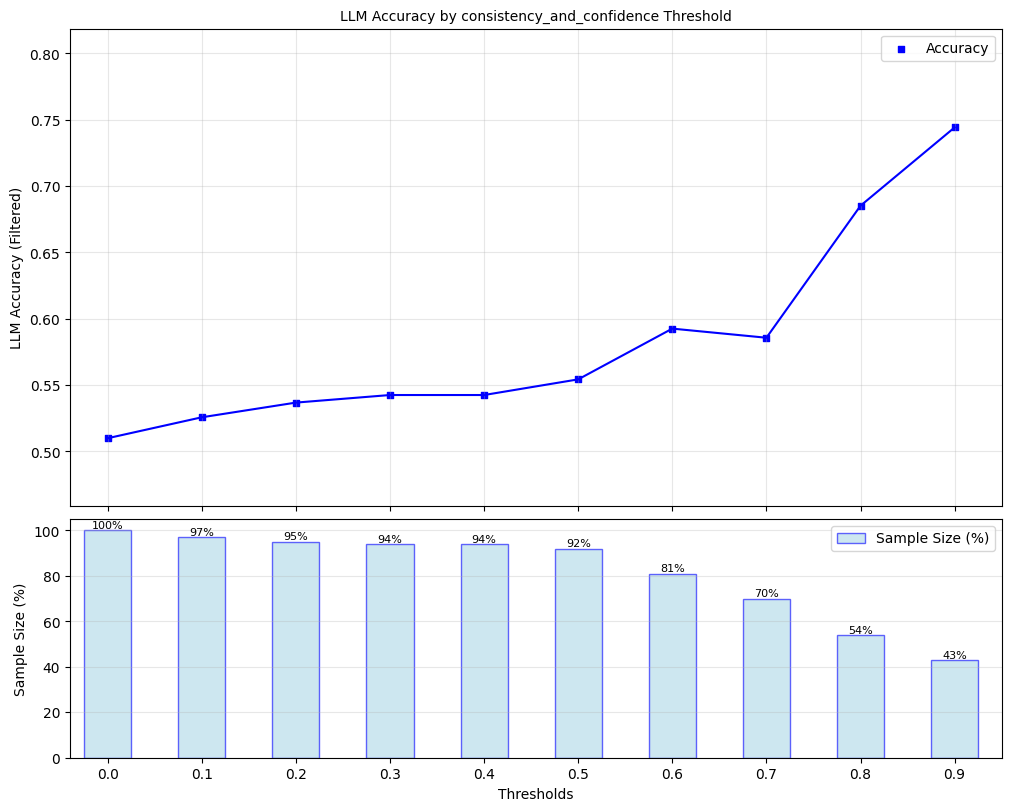

In [11]:
for confidence_score in wbuq.scorers:
    plot_model_accuracies(scores=result_df[confidence_score], correct_indicators=result_df.response_correct, title=f"LLM Accuracy by {confidence_score} Threshold", display_percentage=True)

#### 3.2 Precision, Recall, F1-Score of Hallucination Detection

Lastly, we compute the optimal threshold for binarizing confidence scores, using F1-score as the objective. Using this threshold, we compute precision, recall, and F1-score for white box scorer predictions of whether responses are correct.

In [12]:
# instantiate UQLM tuner object for threshold selection
split = len(result_df) // 2
t = Tuner()

correct_indicators = (result_df.response_correct) * 1  # Whether responses is actually correct
metric_values = {"Precision": [], "Recall": [], "F1-score": []}
optimal_thresholds = []
for confidence_score in wbuq.scorers:
    # tune threshold on first half
    y_scores = result_df[confidence_score]
    y_scores_tune = y_scores[0:split]
    y_true_tune = correct_indicators[0:split]
    best_threshold = t.tune_threshold(y_scores=y_scores_tune, correct_indicators=y_true_tune, thresh_objective="fbeta_score")

    y_pred = [(s > best_threshold) * 1 for s in y_scores]  # predicts whether response is correct based on confidence score
    optimal_thresholds.append(best_threshold)

    # evaluate on last half
    y_true_eval = correct_indicators[split:]
    y_pred_eval = y_pred[split:]
    metric_values["Precision"].append(precision_score(y_true=y_true_eval, y_pred=y_pred_eval))
    metric_values["Recall"].append(recall_score(y_true=y_true_eval, y_pred=y_pred_eval))
    metric_values["F1-score"].append(f1_score(y_true=y_true_eval, y_pred=y_pred_eval))

# print results
header = f"{'Metrics':<25}" + "".join([f"{scorer_name:<25}" for scorer_name in wbuq.scorers])
print("=" * len(header) + "\n" + header + "\n" + "-" * len(header))
for metric in metric_values.keys():
    print(f"{metric:<25}" + "".join([f"{round(x_, 3):<25}" for x_ in metric_values[metric]]))
print("-" * len(header))
print(f"{'F-1 optimal threshold':<25}" + "".join([f"{round(x_, 3):<25}" for x_ in optimal_thresholds]))
print("=" * len(header))

Metrics                  consistency_and_confidence
---------------------------------------------------
Precision                0.6                      
Recall                   0.577                    
F1-score                 0.588                    
---------------------------------------------------
F-1 optimal threshold    0.81                     


© 2025 CVS Health and/or one of its affiliates. All rights reserved.